In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.random.set_seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Load data
- set the load data row number
- set colunms names
- remove useless colunms

In [3]:
row_num = 40000
test_num= 5500
n_time_steps = 30
n_features = 9
n_epoch = 200
batch_size=256

In [4]:
from ppl_util import DataUtil

In [5]:
path_list = ["data/DoS_dataset.csv","data/Fuzzy_dataset.csv","data/gear_dataset.csv",'data/RPM_dataset.csv',"data/normal_run_data.txt"]
data_util = DataUtil(n_row=row_num, path_list=path_list, n_time_step=n_time_steps, n_features=n_features)

In [6]:
dataset = data_util.read_files(is_shuffle=True)
dataset.head()

/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,features,label
2943,"[[0.9999999999999999, 0.0, 0.0, 0.003968253968...",gear
3222,"[[0.6466030989272944, 0.00392156862745098, 0.3...",gear
949,"[[0.4815476190476191, 0.047058823529411764, 0....",DoS
4157,"[[0.09475566150178784, 0.5019607843137255, 0.7...",rpm
4581,"[[0.5232419547079856, 0.0, 0.17391304347826086...",rpm


In [7]:
features, label = data_util.get_train_data()

In [8]:
features.shape

(6474, 30, 9)

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential

In [10]:
from tensorflow.keras.layers import Input,Conv1D,Dropout,MaxPooling1D,Flatten,Dense

In [11]:
divergence_fn = lambda q,p,_: tfd.kl_divergence(q,p)/features.shape[0]
def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

In [12]:
model = Sequential([
    tfpl.Convolution1DReparameterization(
    input_shape=(n_time_steps,n_features),filters=16, kernel_size=3,activation='relu',
    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
    kernel_divergence_fn = divergence_fn,
    bias_prior_fn = tfpl.default_multivariate_normal_fn,
    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
    bias_divergence_fn =  divergence_fn   
    ),
    tfpl.Convolution1DReparameterization(
    filters=16, kernel_size=3,activation='relu',
    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
    kernel_divergence_fn = divergence_fn,
    bias_prior_fn = tfpl.default_multivariate_normal_fn,
    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
    bias_divergence_fn =  divergence_fn   
    ),
#     tfpl.Convolution1DReparameterization(
#     filters=16, kernel_size=3,activation='relu',
#     kernel_prior_fn = tfpl.default_multivariate_normal_fn,
#     kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
#     kernel_divergence_fn = divergence_fn,
#     bias_prior_fn = tfpl.default_multivariate_normal_fn,
#     bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
#     bias_divergence_fn =  divergence_fn   
#     ),
    MaxPooling1D(16),
    Flatten(),
    tfpl.DenseReparameterization(
        units = tfpl.OneHotCategorical.params_size(5),activation=None,
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn = divergence_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn =  divergence_fn   
    ),
    tfpl.OneHotCategorical(5)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization (C (None, 28, 16)            896       
_________________________________________________________________
conv1d_reparameterization_1  (None, 26, 16)            1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense_reparameterization (De (None, 5)                 170       
_________________________________________________________________
one_hot_categorical (OneHotC multiple                  0         
Total params: 2,634
Trainable params: 2,634
Non-trainable params: 0
______________________________________________________

/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [13]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer='adam',
              metrics=['categorical_accuracy'],
              experimental_run_tf_function=False)

In [ ]:
history = model.fit(features[:test_num], label[:test_num], epochs=n_epoch, batch_size=batch_size,
                    validation_data=(features[test_num:], label[test_num:]))

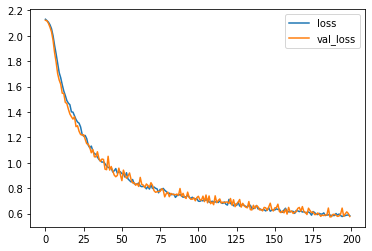

In [15]:
x = list(range(n_epoch))
plt.plot(x, history.history['loss'],label="loss")
plt.plot(x, history.history['val_loss'],label="val_loss")
plt.legend();

In [16]:
np.argmax(label[1])

2

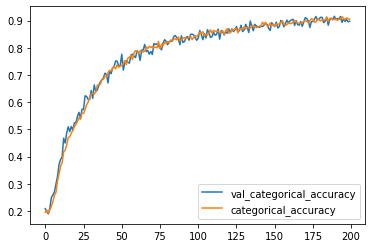

In [17]:
plt.plot(x, history.history['val_categorical_accuracy'],label="val_categorical_accuracy")
plt.plot(x, history.history['categorical_accuracy'],label="categorical_accuracy")
plt.legend();

In [29]:
x_test = features[test_num:]
y_test = dataset.label.to_list()

In [31]:
label_list = ['DoS', 'Fuzzy', 'RPM', 'gear',  'Normal']

In [32]:
def analyse_model_predictions(action_num):
    
    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[action_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True Event:', y_test[action_num])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 5))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[action_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(5)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(5)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(5), pct_97p5, color='red')

    
    bar[data_util.activity_to_label[y_test[action_num]]].set_color('blue')
    bar = ax.bar(np.arange(5), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(label_list,rotation=45, horizontalalignment='right')
    

    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


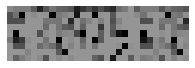

------------------------------
True Event: gear

------------------------------
Model estimated probabilities:


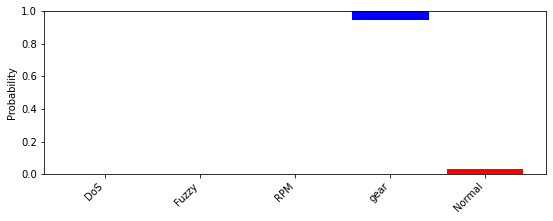

------------------------------
Accelerometer data:


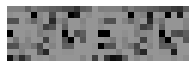

------------------------------
True Event: gear

------------------------------
Model estimated probabilities:


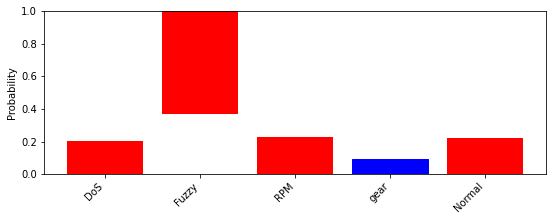

------------------------------
Accelerometer data:


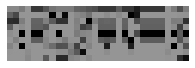

------------------------------
True Event: DoS

------------------------------
Model estimated probabilities:


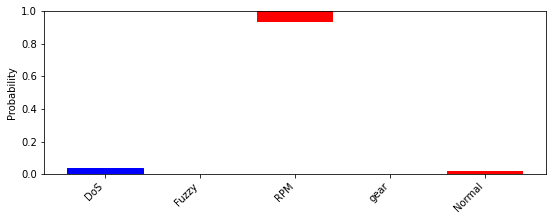

------------------------------
Accelerometer data:


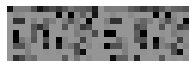

------------------------------
True Event: DoS

------------------------------
Model estimated probabilities:


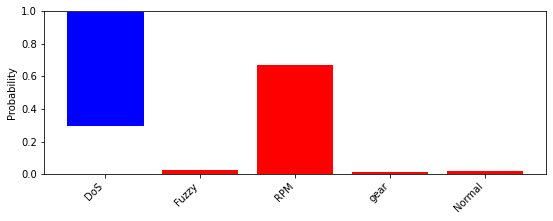

------------------------------
Accelerometer data:


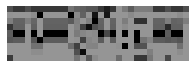

------------------------------
True Event: gear

------------------------------
Model estimated probabilities:


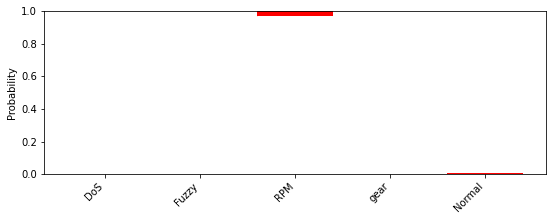

In [33]:
for i in [1,100,250,12,50]:
    analyse_model_predictions(i)